---
title: "Social dimensions of Eaton and Palisades fires"
description: "Exploring the effect of the Eaton and Palisades Fires on Elderly residents in Los Angeles County in 2025."
author: Hylaea Miller
date: "2025-12-01"
categories: [Geospatial, Python]
code-fold: true
toc: true
draft: false
citation: false
---

## **About**
The Palisades and Eaton fires started in Los Angeles County on Jan 7, 2025, burning more than 16,000 structures, forcing mass evacuations, and resulting in at least 28 fatalities (SHANE, 2025). Understanding the social dimensions of wildfire impacts is crucial for effective disaster response and recovery.

This blog post analyzes the 2025 Eaton and Palisades Fires in Los Angeles County using Landsat 8 satellite imagery to create false-color composites that highlight burned areas and vegetation damage, and includes an analysis of the social impact on elderly residents using the Environmental Justice Index (EJI) dataset.

The complete code and analysis for this project can be found here: [GitHub repository](https://github.com/hylaea-miller/eds220-hwk4.git)


### **Highlights**

- Data wrangling and exploration using `pandas` and `numpy`
- Geospatial analysis of false and true color images with `geopandas` and `rioxarray`
- Creating visualizations with `matplotlib` to analyze the spatial distribution of elderly populations in areas affected by the Eaton and Palisades fires


### **Data Information**

**Landsat Collection of bands**

Contains a simplified collection of bands (red, green, blue, near-infrared, and shortwave infrared) from the Landsat Collection 2 Level-2 atmospherically corrected surface reflectance data, collected by the Landsat 8 satellite. Download here: [Landsat Collection](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)

**Palisades and Eaton Dissolved Fire Perimeters**

Contains dissolved fire perimeters/boundaries for the Eaton and Palisades fires. Download here: [Fire Perimeters](https://geohub.lacity.org/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about)

**Environmental Justice Index (EJI) data**

Contains 2024 census tract-level data on environmental and socioeconomic factors for California, including the percentage of elderly residents (age 65 and older) used in this analysis. Download here: [EJI](https://www.atsdr.cdc.gov/place-health/php/eji/eji-data-download.html)


### Setup: Import Libraries and Data

Load the necessary packages, and import Landsat bands, fire perimeters, and EJI data.

In [2]:
# Loading necessary libraries
import os              
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr   
import geopandas as gpd
import contextily as ctx

# Load Landsat data from NetCDF file
landsat = xr.open_dataset("data/landsat8-2025-02-23-palisades-eaton.nc")

# Load Eaton perimeter shapefile
fp = os.path.join('data', 'Eaton_Perimeter_20250121.shp')
eaton = gpd.read_file(fp)

# Load Palisades perimeter shapefiles
fp = os.path.join('data', 'Palisades_Perimeter_20250121.shp')
palisades = gpd.read_file(fp)

# Load EJI
fp = os.path.join('data', 'EJI_2024_California.gdb')
eji = gpd.read_file(fp)

## Prepare Landsat Data

This dataset does not currently have a CRS assigned, indicating it is not a geospatial object. To restore the geospatial information, we will use the `rio.write_crs()` function to assign the correct CRS to the dataset.
The appropriate CRS for Landsat 8 data is EPSG:32611 (WGS 84 / UTM zone 11N), retrieved from the `spatial_ref` metadata attribute.


In [29]:
#| output: false
# Write the correct CRS
landsat.rio.write_crs("WGS 84 / UTM zone 11N", inplace=True)

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
    spatial_ref  int32 4B 0
Data variables:
    red          (y, x) float32 16MB 1.024e+04 9.886e+03 ... 1.019e+04 9.967e+03
    green        (y, x) float32 16MB 9.93e+03 9.687e+03 ... 9.984e+03 9.662e+03
    blue         (y, x) float32 16MB 9.29e+03 9.183e+03 ... 9.49e+03 9.187e+03
    nir08        (y, x) float32 16MB 1.331e+04 1.313e+04 ... 1.287e+04 1.306e+04
    swir22       (y, x) float32 16MB 1.43e+04 1.437e+04 ... 1.406e+04 1.329e+04

It is important to check and handle any missing values (NaNs) in the data before creating the composite image. Missing values can lead to inaccuracies in the visualization and analysis, and in this case will give us warning messages when plotting the data.

In [30]:
#| output: false
# Check for missing data in red, green, and blue bands
print(np.isnan(landsat[["red", "green","blue"]]).sum())

# Fill NaN values with 0
landsat = landsat.fillna(0)

<xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
    spatial_ref  int32 4B 0
Data variables:
    red          int32 4B 0
    green        int32 4B 0
    blue         int32 4B 0


## True Color Composite

Before analyzing the fire impact, we will create a true color composite image using the red, green, and blue bands from the Landsat dataset. This composite will provide a visual representation of true colors as seen by the human eye of the area affected by the Eaton and Palisades fires.

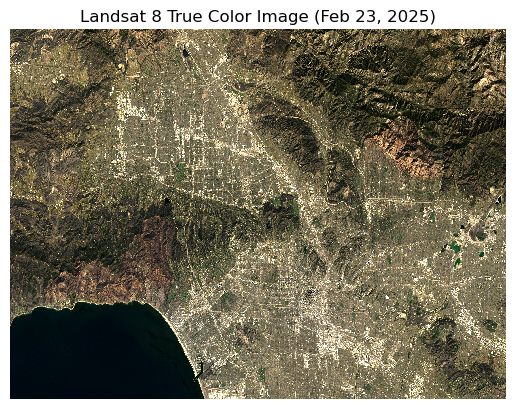

In [31]:
# Create a true color image with robust scaling
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
plt.title('Landsat 8 True Color Image (Feb 23, 2025)')
plt.axis('off')
plt.show()

The `robust=True` parameter adjusts the color scaling, preventing outliers from dominating and allowing the image to display correctly, while filling NaN values with zero prevents gaps in the data and warning messages.

## False Color Composite
False color composites are useful for highlighting specific features in satellite imagery that may not be as easily discernible in true color images.

We are creating a false color image by assigning the short-wave infrared (swir22), near-infrared, and red bands to the red, green, and blue channels, respectively.

(334395.0, 416655.0, 3756525.0, 3799065.0)

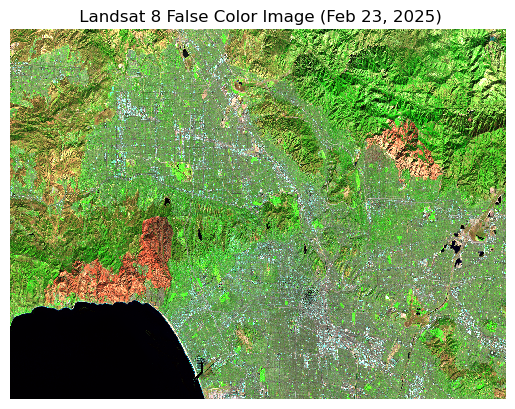

In [21]:
# Plot a false color image using SWIR, NIR, and Red bands
landsat[['swir22', 'nir08', 'red']].to_array().fillna(0).plot.imshow(robust = True)
plt.title(' Landsat 8 False Color Image (Feb 23, 2025)')
plt.axis('off')

### Visualize false color image with fire perimeters

To visualize the impact of the Eaton and Palisades fires, we will overlay the fire perimeters on top of the false color composite image. This will require reprojecting the fire perimeter data to match the CRS of the Landsat data.

In [7]:
# Reproject the fire extends to the landsat dataset
eaton = eaton.to_crs(landsat.rio.crs)
palisades = palisades.to_crs(landsat.rio.crs)

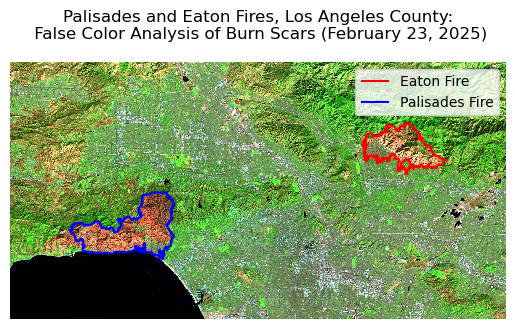

In [8]:
# Plot false color image with fire perimeters
fig, ax = plt.subplots()
landsat[['swir22', 'nir08', 'red']].to_array().fillna(0).plot.imshow(ax=ax, robust=True)
eaton.boundary.plot(ax=ax, edgecolor='red', label='Eaton Fire')
palisades.boundary.plot(ax=ax, edgecolor='blue', label='Palisades Fire')
ax.set_title('Palisades and Eaton Fires, Los Angeles County:\n False Color Analysis of Burn Scars (February 23, 2025)')
ax.legend()
ax.axis('off')
plt.show()

**Figure Interpretation**

This figure displays a false color composite image of the Los Angeles County fires using SWIR, NIR, and red bands assigned to RGB channels, respectively, to highlight the burned areas from the Palisades and Eaton fires. The imagery was acquired by Landsat 8 on February 23, 2025.

Healthy vegetation appears in shades of bright green due to high reflectance in the near-infrared band, while burned areas are shown in shades of brown and magenta, indicating low reflectance in both the shortwave infrared and near-infrared bands. Fire perimeters are overlaid on the image, with the Palisades Fire outlined in blue and the Eaton Fire outlined in red, allowing for easy identification of the affected areas.

## Prepare EJI Data

The EJI dataset contains various socioeconomic and environmental variables at the census tract level. For this analysis, we will focus on the percentage of elderly residents (age 65 and older). We will reproject the EJI data to match the CRS of the Landsat data for accurate spatial analysis, and clip the EJI data to the extent of the fire perimeters to focus on the areas affected by the fires.

Match the CRS of the EJI data to that of the Landsat data using the `.to_crs()` method.

In [9]:
# Match the CRS of the eji data to the fire perimeter
eji = eji.to_crs(palisades.crs)

Clip the EJI data to the extent of the fire perimeters using the `.clip()` method.

In [10]:
# Clip the census tracts to the Palisades fire perimeter using geopandas.clip()
eji_pali = gpd.clip(eji, palisades)
# Clip the census tracts to the Eaton fire perimeter using geopandas.clip()
eji_eaton = gpd.clip(eji, eaton)

## Visualize EJI data 

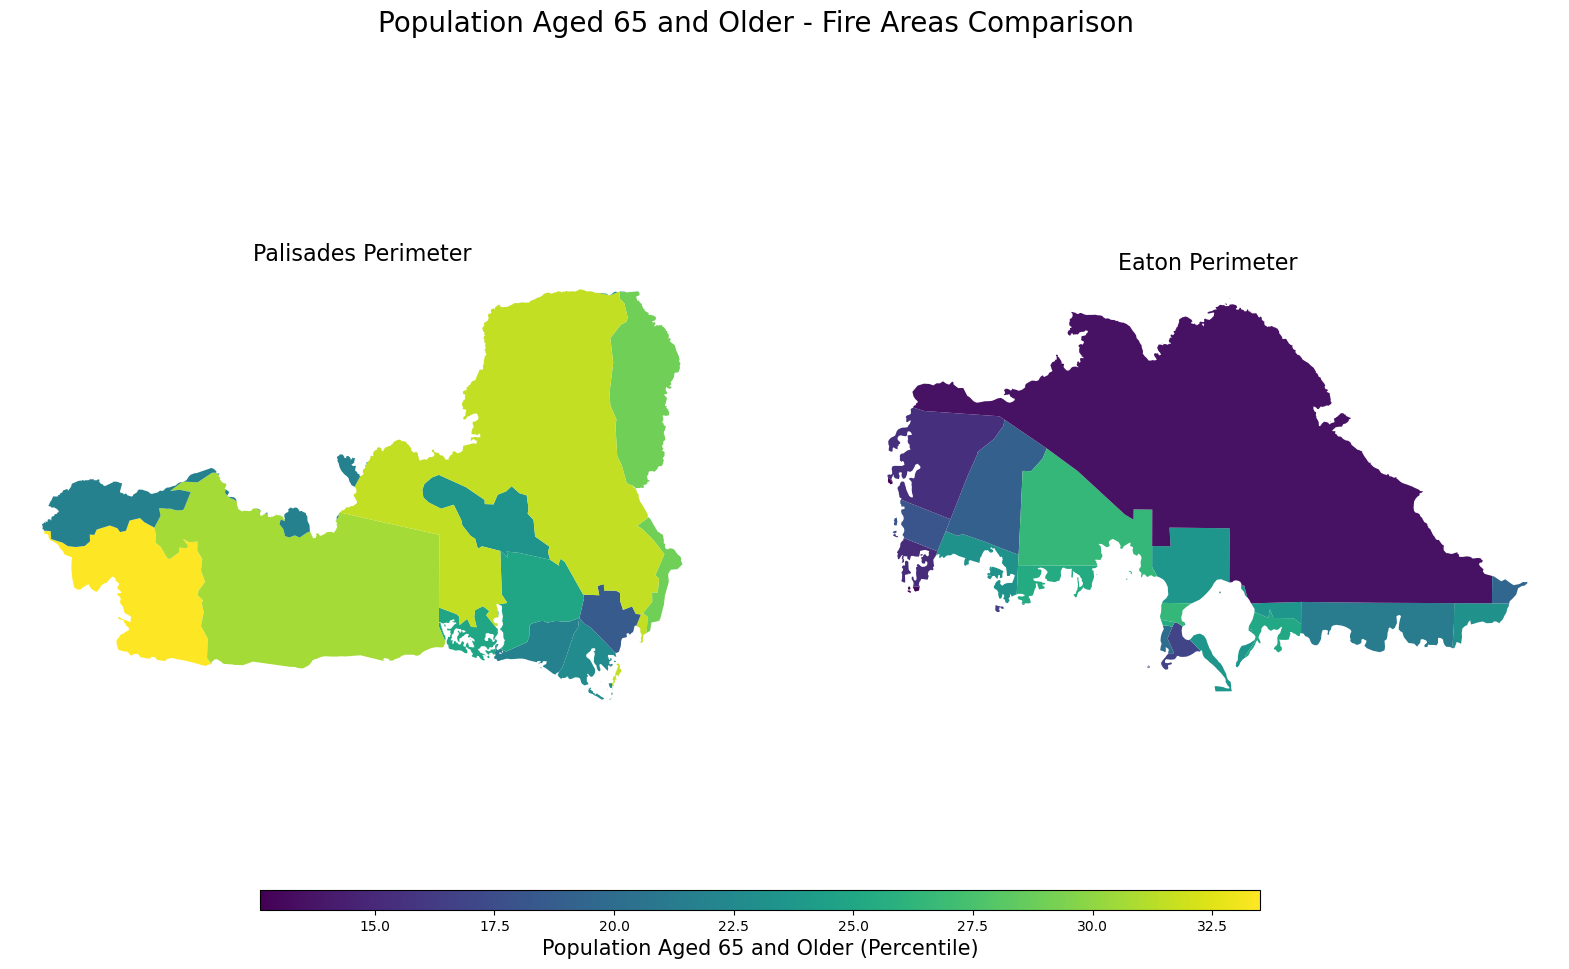

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# UPDATE WITH YOU EJI VARIABLE FROM STEP 1
eji_variable = 'E_AGE65'

# Find common min/max for legend range
vmin = min(eji_pali[eji_variable].min(), eji_eaton[eji_variable].min())
vmax = max(eji_pali[eji_variable].max(), eji_eaton[eji_variable].max())

# Plot census tracts within Palisades perimeter
eji_pali.plot(
    column= eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
)
ax1.set_title('Palisades Perimeter', fontsize=16)
ax1.axis('off')

# Plot census tracts within Eaton perimeter
eji_eaton.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
)
ax2.set_title('Eaton Perimeter', fontsize=16)
ax2.axis('off')

# Add overall title
fig.suptitle('Population Aged 65 and Older - Fire Areas Comparison ', fontsize=20)

# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Population Aged 65 and Older (Percentile)', fontsize=15)

plt.show()

**Figure Interpretation**

The variable Population Aged 65 and Older (E_AGE65) shows a different distribution across the two fire perimeters. In the Palisades fire perimeter, there is a higher concentration of census tracts with elevated percentiles of elderly residents compared to the Eaton fire perimeter. This suggests that the Palisades area have a larger proportion of older adults who could face greater challenges during wildfire events, such as mobility issues and health vulnerabilities. Consequently, wildfire relief efforts in the Palisades area may need to prioritize resources for evacuation assistance, medical support, and community outreach tailored to the needs of elderly residents. In contrast, the Eaton fire perimeter may require different strategies focused on other demographic factors present in that area.



### **References:**
Microsoft Planetary Computer. (2025). Landsat Collection 2 Level-2. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2.
[Accessed: November 19, 2025]

National Interagency Fire Center (NIFC). (2025). Palisades and Eaton 
Fire Perimeters [Dataset]. Los Angeles GeoHub. https://geohub.lacity.org/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about 
[Accessed: November 19, 2025]‌

NASA Earth Observatory. (2014, March 14). Why is that Forest Red and that Cloud Blue? How to Interpret a False-Color Satellite Image. NASA Science. https://science.nasa.gov/earth/earth-observatory/how-to-interpret-a-false-color-satellite-image/
[Accessed: November 20, 2025]

Philips, Shane (2025, November 17). The Palisades and Eaton Fires: Neighborhood Data and Potential Housing Market Effects. UCLA Lewis Center for Regional Policy Studies. https://www.lewis.ucla.edu/research/the-palisades-and-eaton-fires-neighborhood-data-and-potential-housing-market-effects/[Accessed: November 30, 2025]

‌